In [1]:
import os

import numpy as np
from netCDF4 import Dataset
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pd.set_option('display.max_rows', None)

In [2]:
#gsi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/2023061012/diag_conv_qonly_2"
gsi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/gsi_prepbufr_analysis/2023061012/anal_conv_dbz_gsi_qonly_noerradj_nocloseobs"
gsi_hofx_suffix = "conv_q_01.nc4"
#gsi_hofx_suffix = "conv_t_01.nc4"
#gsi_group = "Errinv_Final"
gsi_group = "Obs_Minus_Forecast_adjusted"
#gsi_group = "Observation"
plot_hofx = True
jedi_hofx_dir = "/work/noaa/wrfruc/span/jedi_summer_retro/jedi_prepbufr_analysis/2023061012/hofx"
jedi_hofx_filename = "hofx_adpsfc_qonly.nc"
#jedi_hofx_filename = "hofx_adpsfc_tonly.nc"
#jedi_group = "EffectiveError0"
jedi_group = "hofx0"
#jedi_group = "ObsValue"
jedi_varname = "specificHumidity"
#jedi_varname = "airTemperature"

reference_time = "2023-06-10_12:00:00"

colormap="coolwarm"

In [3]:
def read_gsi(file_dir, filename_suffix, groupname, is_hofx=False, flag=1):
    # List all files in the directory that match the pattern pe{proc}.conv_q_01.nc4
    hofx_files = [os.path.join(file_dir, f) for f in os.listdir(file_dir) if f.endswith(filename_suffix)]

    all_latitudes = np.empty((0,))
    all_longitudes = np.empty((0,))
    all_pressures = np.empty((0,))
    all_times = np.empty((0,))
    all_values = np.empty((0,))
    have_data = False

    # Loop over each file and extract the required data
    for index, file in enumerate(hofx_files):
        with Dataset(file, "r") as nc_file:
            # Read the relevant variables
            try:
                flags = nc_file.variables["Analysis_Use_Flag"][:]
                lats = nc_file.variables['Latitude'][:][flags == flag]
                lons = nc_file.variables['Longitude'][:][flags == flag]
                press = nc_file.variables['Pressure'][:][flags == flag]
                time = nc_file.variables['Time'][:][flags == flag]
                if is_hofx:
                    values = nc_file.variables["Observation"][:][flags == flag] - nc_file.variables[groupname][:][flags == flag]
                else:
                    values = nc_file.variables[groupname][:][flags == flag]
                if "Errinv" in groupname:
                    values = 1.0 / values
                if "conv_q" in filename_suffix :
                    values = values * 1000
                have_data = True
            except:
                have_data = False
                print(f"No data in file: {file}")

        if have_data:
            all_latitudes = np.append(all_latitudes, lats)
            all_longitudes = np.append(all_longitudes, lons)
            all_pressures = np.append(all_pressures, press)
            all_times = np.append(all_times, time)
            all_values = np.append(all_values, values)

    return all_latitudes, all_longitudes, all_pressures, all_times, all_values

In [4]:
def read_jedi(file_dir, filename, groupname, varname, flag=0):
    # Load the NetCDF file
    nc_file = os.path.join(file_dir, filename)
    nc_data = Dataset(nc_file, "r")

    # Extract latitude, longitude, and values
    flags = nc_data.groups["EffectiveQC0"].variables[varname][:]
    lats = nc_data.groups["MetaData"].variables["latitude"][:][flags == flag]
    lons = nc_data.groups["MetaData"].variables["longitude"][:][flags == flag]
    press = nc_data.groups["MetaData"].variables["pressure"][:][flags == flag]
    time = nc_data.groups["MetaData"].variables["dateTime"][:][flags == flag]
    values = nc_data.groups[groupname].variables[varname][:][flags == flag]
    if varname in ["specificHumidity", ]:
        values = values * 1000

    return lats, lons, press, time, values

In [5]:
def obs_validation(df_gsi, df_jedi):
    merged_df = pd.merge(df_gsi, df_jedi, on=['lats', 'lons', 'press'], suffixes=('_gsi', '_jedi'), how='inner')

    # Calculate time difference
    merged_df['time_diff'] = (merged_df['time_gsi'] - merged_df['time_jedi'])

    # Filter rows where time difference is within 10 seconds
    merged_df = merged_df[merged_df['time_diff'].abs() < 10]

    # Calculate value difference
    merged_df['diff_values'] = merged_df['values_gsi'] - merged_df['values_jedi']

    final_df = merged_df[['lats', 'lons', 'press', 'time_jedi', 'values_gsi', 'values_jedi', 'diff_values']]
    final_df.columns = ['lats', 'lons', 'press', 'time', 'values_gsi', 'values_jedi', 'diff_values']

    return final_df

In [6]:
def variable_scatter(lons, lats, values, colormap="terrain", markersize=1.0, alpha=1.0,
                     minval=None, maxval=None, area=[-140, -50, 20, 60], clon=-95, clat=40,
                     system=None, varname=None, vartype=None, is_hofx=False):
    fig = plt.figure(figsize=(20, 16))

    cartopy.config['data_dir'] = "/work2/noaa/wrfruc/span/natural_earth_data"
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40,
                                       standard_parallels=(clat-5, clat+5))
    #projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    ax = plt.axes(projection=projection)
    ax.set_extent(area, crs=ccrs.PlateCarree())
    
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, zorder=0)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
    ax.add_feature(ocean, zorder=0)
    
    # Add coastlines
    coast = cfeature.NaturalEarthFeature(category='physical', scale='50m', name='coastline')
    ax.add_feature(coast, edgecolor='black', facecolor='none', linewidth=0.5)
    
    # Add country borders
    countries = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_0_countries')
    ax.add_feature(countries, edgecolor='black', facecolor='none', linewidth=0.7)
    
    # Add state lines
    states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', name='admin_1_states_provinces')
    ax.add_feature(states, edgecolor='gray', facecolor='none', linewidth=0.5)

    sc = ax.scatter(lons, lats, c=values, cmap=colormap, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), s=markersize, alpha=alpha)

    # Calculate the min and max of the values array
    n_obs = values.shape[0]
    min_value = np.min(values)
    max_value = np.max(values)
    mean_value = np.mean(values)
    stdev_value = np.std(values)

    # Add text for the min and max values in the bottom left corner of the map
    text_str = f"Number of Obs: {n_obs:4}\nMin Value: {min_value:.4f} \
                 \nMax Value: {max_value:.4f}\nMean Value: {mean_value:.4f} \
                 \nStandard Deviation: {stdev_value:.4f}"
    ax.text(area[0] + 1, area[2] - 1, text_str, transform=ccrs.PlateCarree(),
            fontsize=18, verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Add a colorbar at the bottom
    if "Errinv" in vartype:
        cblabel = system + " " + varname + " 1/" + vartype
    else:
        if is_hofx:
            cblabel = system + " " + varname + " HofX"
        else:
            cblabel = system + " " + varname + " " + vartype
    cbar = plt.colorbar(sc, label=cblabel, orientation='horizontal', shrink=0.8, aspect=50, pad=0.01)

In [7]:
# Plotting
def valication_scatter(merged_df, var_prefix="HofX"):

    # Calculate R-squared
    r_squared = r2_score(merged_df['values_gsi'], merged_df['values_jedi'])
    # Fit linear regression model
    slope, intercept = np.polyfit(merged_df['values_gsi'], merged_df['values_jedi'], 1)
    
    plt.figure(figsize=(16, 12))
    plt.scatter(merged_df['values_gsi'], merged_df['values_jedi'], color='blue', label='Validation Plot')
    plt.plot([merged_df['values_gsi'].min(), merged_df['values_gsi'].max()], 
             [merged_df['values_gsi'].min(), merged_df['values_gsi'].max()], 
             color='red', label='1:1 Line')
    plt.plot(merged_df['values_gsi'], slope * merged_df['values_gsi'] + intercept, 
             color='red', linestyle='--', label=f'$y = {slope:.2f}x + {intercept:.2f}$')
    plt.xlabel(var_prefix+'_gsi')
    plt.ylabel(var_prefix+'_jedi')
    plt.title(f'Validation Plot: GSI vs JEDI\n$R^2$ = {r_squared:.2f}')
    plt.legend()
    plt.grid(True)

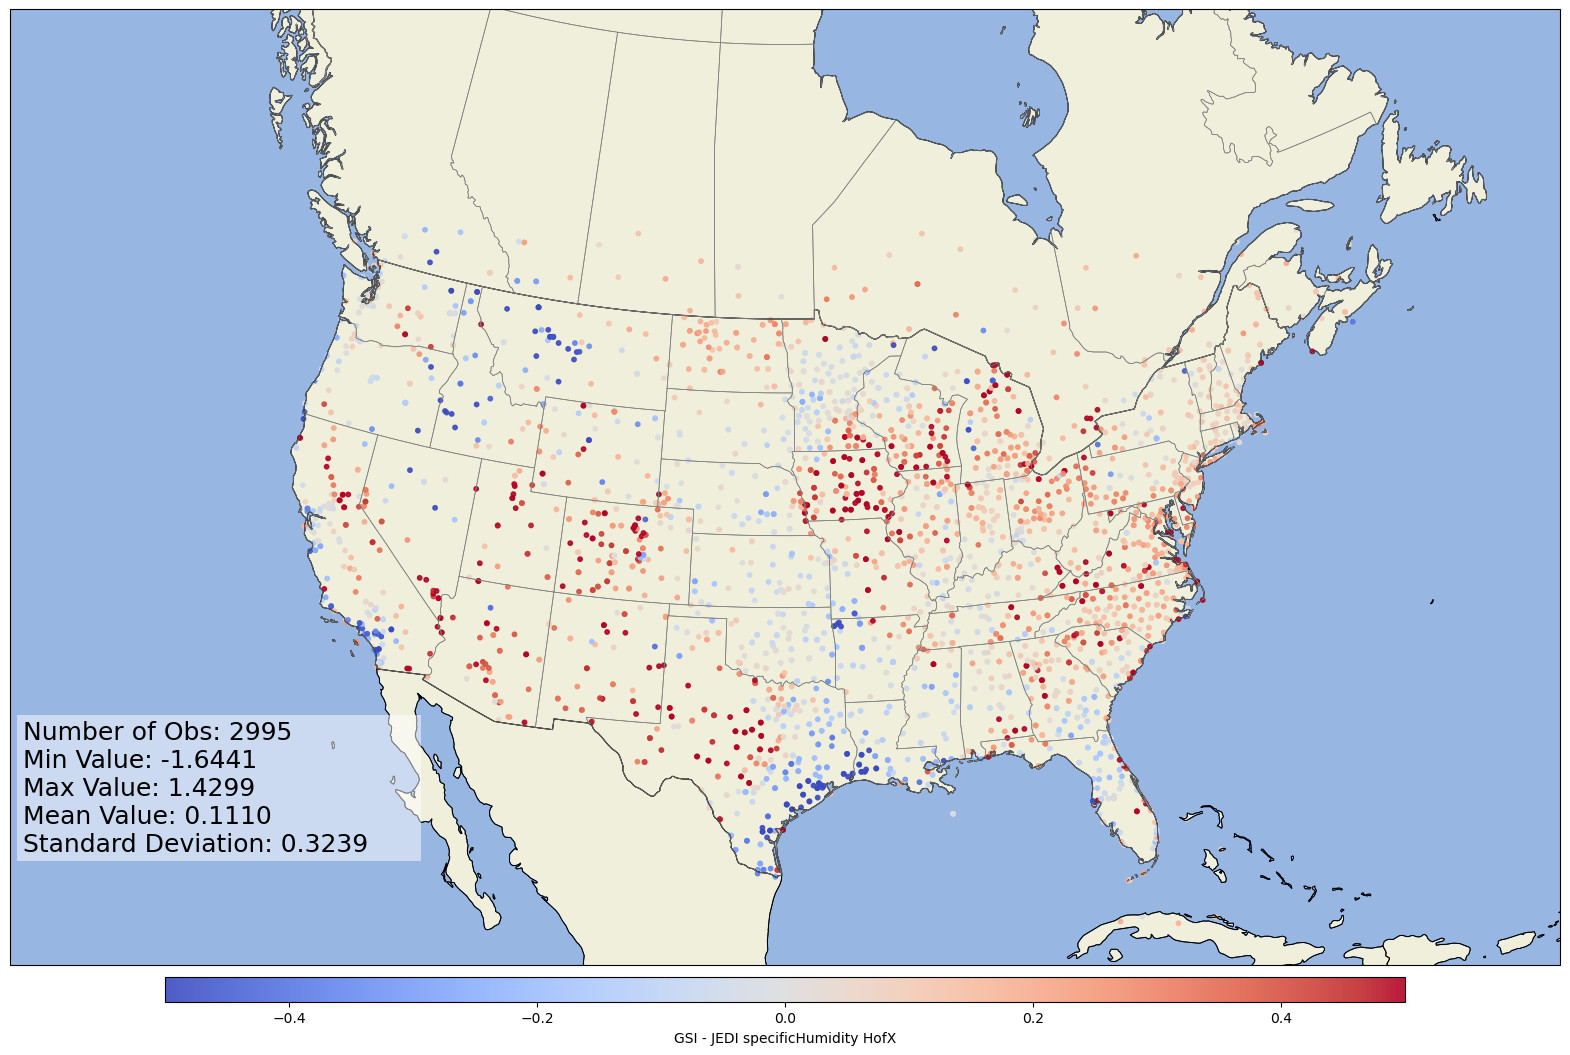

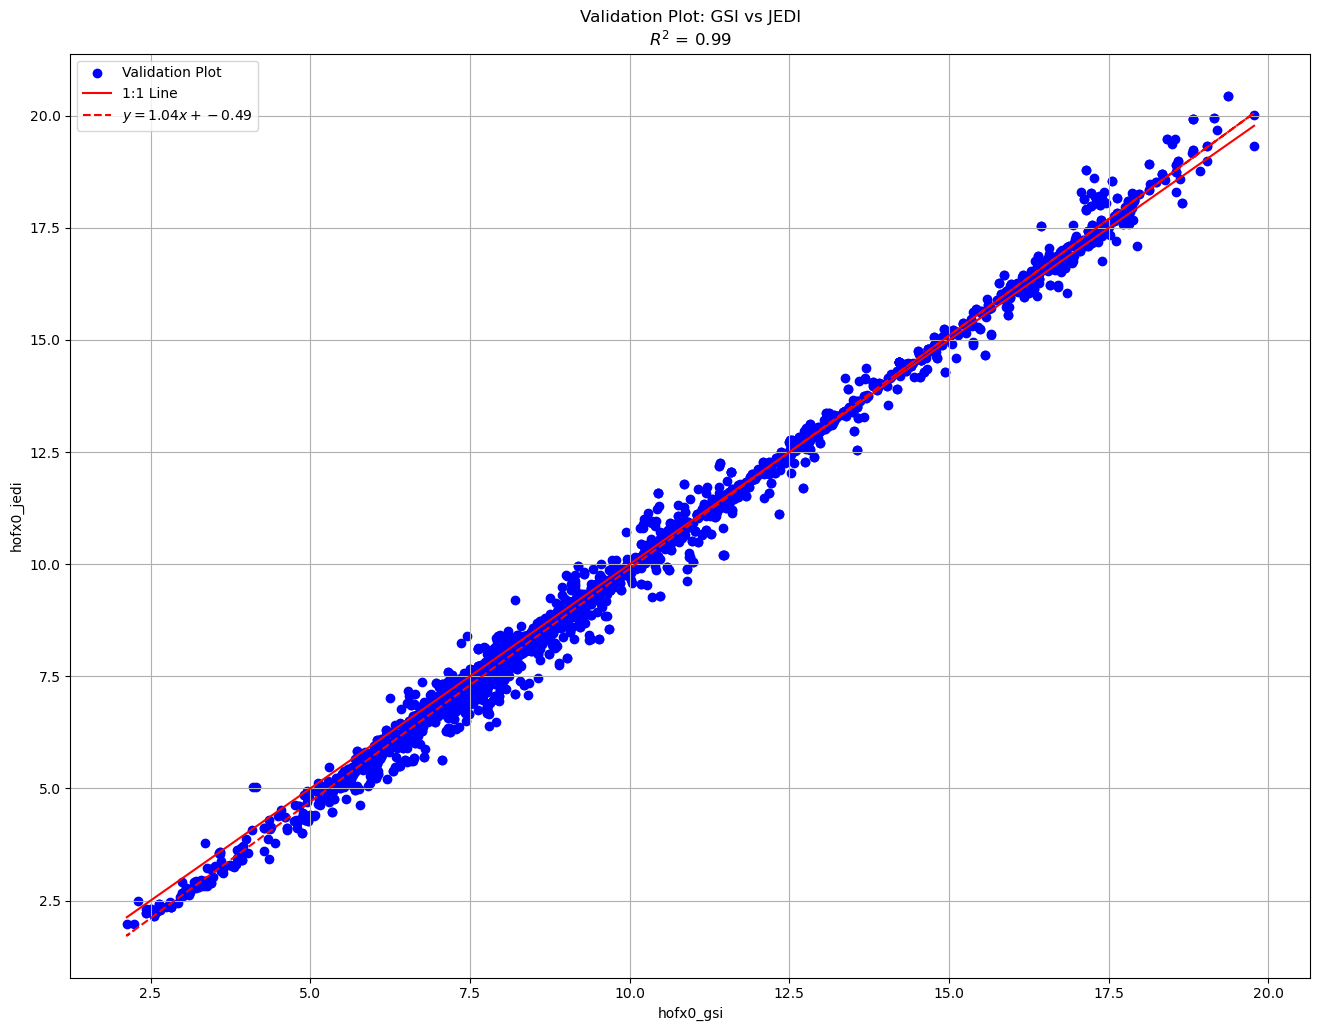

In [9]:
if __name__ == "__main__":

    gsi_lats, gsi_lons, gsi_press, gsi_time, gsi_values = read_gsi(gsi_hofx_dir, gsi_hofx_suffix, gsi_group, plot_hofx, flag=1)
    data_gsi = np.column_stack((gsi_lats, gsi_lons, gsi_press*100, gsi_time*3600, gsi_values))
    df_gsi = pd.DataFrame(data_gsi, columns=['lats', 'lons', 'press', 'time', 'values'])
    df_gsi['press'] = df_gsi['press'].round()
    df_gsi['time'] = df_gsi['time'].round()
    
    jedi_lats, jedi_lons, jedi_press, jedi_time, jedi_values = read_jedi(jedi_hofx_dir, jedi_hofx_filename, jedi_group, jedi_varname, flag=0)
    data_jedi = np.column_stack((jedi_lats, jedi_lons, jedi_press, jedi_time, jedi_values))
    df_jedi = pd.DataFrame(data_jedi, columns=['lats', 'lons', 'press', 'time', 'values'])
    seconds_since_epoch = (datetime.strptime(reference_time, "%Y-%m-%d_%H:%M:%S") - datetime(1970, 1, 1)).total_seconds()
    df_jedi["time"] = df_jedi["time"] - seconds_since_epoch

    validated_obs = obs_validation(df_gsi=df_gsi, df_jedi=df_jedi)
    
    maxlat = 58
    minlat = 22
    maxlon = -63
    minlon = -131
    maxval = 0.5
    minval = -0.5

    lons = validated_obs["lons"].to_numpy()
    lats = validated_obs["lats"].to_numpy()
    differences = validated_obs["diff_values"].to_numpy()
    variable_scatter(lons, lats, differences, colormap, markersize=10, alpha=0.9, minval=minval, maxval=maxval,
                     area=[minlon, maxlon, minlat, maxlat], clon=(maxlon+minlon)/2.0, clat=(minlat+maxlat)/2.0,
                     system="GSI - JEDI", varname=jedi_varname, vartype=gsi_group, is_hofx=plot_hofx)

    valication_scatter(validated_obs, var_prefix=jedi_group)